# Implement SLAM 

SLAM gives us a way to both localize a robot and build up a map of its environment as a robot moves and senses in real-time. 

Defining a function, `slam`, which takes in six parameters as input and returns the vector `mu`. 
`mu` contains the (x,y) coordinate locations of the robot as it moves, and the positions of landmarks that it senses in the world

For example, if there were 2 poses and 2 landmarks, `mu` will look like the following, where `P` is the robot position and `L` the landmark position:
```
mu =  matrix([[Px0],
              [Py0],
              [Px1],
              [Py1],
              [Lx0],
              [Ly0],
              [Lx1],
              [Ly1]])
```

You can see that `mu` holds the poses first `(x0, y0), (x1, y1), ...,` then the landmark locations at the end of the matrix; we consider a `nx1` matrix to be a vector.

## Generating an environment

We will make our own data using the `make_data` function, which generates a world grid with landmarks in it and then generates data by placing a robot in that world and moving and sensing over some numer of time steps. The data is collected as an instantiated robot moves and senses in a world. The SLAM function will take in this data as input.

## Create the world

Use the code below to generate a world of a specified size with randomly generated landmark locations. You can change these parameters and see how your implementation of SLAM responds! 

`data` holds the sensors measurements and motion of your robot over time. It stores the measurements as `data[i][0]` and the motion as `data[i][1]`.

#### Helper functions

In the `helpers.py` file, you can read the details of how data is made with the `make_data` function.

In [ ]:
import numpy as np
from helpers import make_data

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 

# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[13, 39], [62, 93], [81, 80], [79, 84], [37, 28]]
Robot: [x=39.38765 y=39.82818]


In [13]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -35.48229979803855, -9.211483602640792], [1, 13.545470078238537, 43.62433825095455], [2, 32.67578718095895, 31.97220057770904], [3, 28.304179791835942, 33.100706642385006], [4, -12.61946902312913, -20.578214048635395]]


Example motion: 
 [0.6853847372217958, 19.988252744099057]


### Initializing omega and xi

`initialize_constraints` returns `omega` and `xi` constraints for the starting position of the robot. Any values that we do not yet know should be initialized with the value `0`. Assuming the robot starts out in exactly the middle of the world with 100% confidence (no motion or measurement noise at this point). The inputs `N` time steps, `num_landmarks`, and `world_size` should give you all the information you need to construct intial constraints of the correct size and starting values.

In [ ]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    # The constraint matrix size is 2*(N poses + num_landmarks) since each has x,y coordinates
    matrix_size = 2 * (N + num_landmarks)
    
    # Initialize omega as a matrix of zeros
    omega = np.zeros((matrix_size, matrix_size))
    # Set initial confidence for the robot's starting position (first pose)
    # x position of first pose at index 0
    omega[0, 0] = 1.0
    # y position of first pose at index 1
    omega[1, 1] = 1.0
    
    ## assume that the robot starts out in the middle of the world with 100% confidence
    xi = np.zeros((matrix_size, 1))
    # Robot starts at center of world
    xi[0, 0] = world_size / 2.0  # initial x position
    xi[1, 0] = world_size / 2.0  # initial y position
    
    return omega, xi

### Testing

Let's check that they initialize as expected for any given parameters.

To visualize the results of your function `initialize_constraints`. We are using the [seaborn](https://seaborn.pydata.org/) library for visualization.

In [4]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [5]:
# define a small N and world_size (small for ease of visualization)
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

<Axes: >

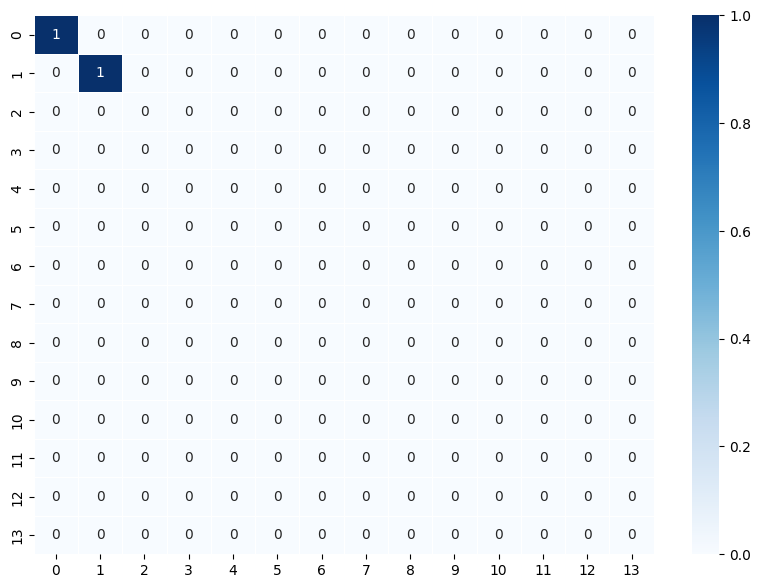

In [6]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

<Axes: >

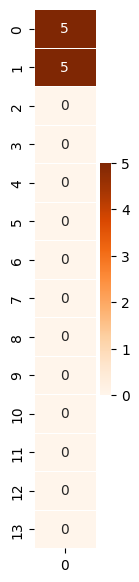

In [7]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

---
## SLAM inputs 

In addition to `data`, the slam function will also take in:
* N -   The number of time steps that a robot will be moving and sensing
* num_landmarks - The number of landmarks in the world
* world_size - The size (w/h) of your world
* motion_noise - The noise associated with motion; the update confidence for motion should be `1.0/motion_noise`
* measurement_noise - The noise associated with measurement/sensing; the update weight for measurement should be `1.0/measurement_noise`

#### A note on noise

Recall that `omega` holds the relative "strengths" or weights for each position variable, and you can update these weights by accessing the correct index in omega `omega[row][col]` and *adding/subtracting* `1.0/noise` where `noise` is measurement or motion noise. `Xi` holds actual position values, and so to update `xi` you'll do a similar addition process only using the actual value of a motion or measurement. So for a vector index `xi[row][0]` you will end up adding/subtracting one measurement or motion divided by their respective `noise`.

### Implement Graph SLAM


#### Updating with motion and measurements

With a 2D omega and xi structure as shown above you'll have to be mindful about how you update the values in these constraint matrices to account for motion and measurement constraints in the x and y directions. The vector 'mu' holds all values for robot poses `P` and landmark locations `L` which can be computed at the end of the construction of omega and xi as the inverse of omega times xi: $\mu = \Omega^{-1}\xi$

In [ ]:
## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    ## initilization to create constraint matrices, omega and xi
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    
    ## get all the motion and measurement data as you iterate
    for t in range(len(data)):
        # Get measurement and motion data at time t
        measurement = data[t][0]  # list of [landmark_index, dx, dy]
        motion = data[t][1]        # [dx, dy]
        
        # Update for measurements
        for m in measurement:
            # m is [landmark_index, dx, dy]
            landmark_index = int(m[0])
            # Measured distance from robot to landmark
            meas_x = m[1]
            meas_y = m[2]
            
            # Indices in the constraint matrix
            # Robot pose at time t: indices 2*t (x) and 2*t+1 (y)
            pose_x_idx = 2 * t
            pose_y_idx = 2 * t + 1
            
            # Landmark position: indices 2*(N + landmark_index) (x) and 2*(N + landmark_index)+1 (y)
            landmark_x_idx = 2 * (N + landmark_index)
            landmark_y_idx = 2 * (N + landmark_index) + 1
            
            # Measurement noise weight
            measure_weight = 1.0 / measurement_noise
            
            # Update omega and xi for x coordinate
            # The constraint is: landmark_x - pose_x = meas_x
            # This adds constraints between the landmark and robot pose
            omega[pose_x_idx, pose_x_idx] += measure_weight
            omega[landmark_x_idx, landmark_x_idx] += measure_weight
            omega[pose_x_idx, landmark_x_idx] -= measure_weight
            omega[landmark_x_idx, pose_x_idx] -= measure_weight
            
            xi[pose_x_idx, 0] -= meas_x * measure_weight
            xi[landmark_x_idx, 0] += meas_x * measure_weight
            
            # Update omega and xi for y coordinate
            omega[pose_y_idx, pose_y_idx] += measure_weight
            omega[landmark_y_idx, landmark_y_idx] += measure_weight
            omega[pose_y_idx, landmark_y_idx] -= measure_weight
            omega[landmark_y_idx, pose_y_idx] -= measure_weight
            
            xi[pose_y_idx, 0] -= meas_y * measure_weight
            xi[landmark_y_idx, 0] += meas_y * measure_weight
        
        # Update for motion
        # Motion connects current pose to next pose
        if t < len(data) - 1:
            # Motion noise weight
            motion_weight = 1.0 / motion_noise
            
            # Indices for current and next poses
            curr_x_idx = 2 * t
            curr_y_idx = 2 * t + 1
            next_x_idx = 2 * (t + 1)
            next_y_idx = 2 * (t + 1) + 1
            
            # Motion x
            dx = motion[0]
            # Constraint: next_x - curr_x = dx
            omega[curr_x_idx, curr_x_idx] += motion_weight
            omega[next_x_idx, next_x_idx] += motion_weight
            omega[curr_x_idx, next_x_idx] -= motion_weight
            omega[next_x_idx, curr_x_idx] -= motion_weight
            
            xi[curr_x_idx, 0] -= dx * motion_weight
            xi[next_x_idx, 0] += dx * motion_weight
            
            # Motion y
            dy = motion[1]
            # Constraint: next_y - curr_y = dy
            omega[curr_y_idx, curr_y_idx] += motion_weight
            omega[next_y_idx, next_y_idx] += motion_weight
            omega[curr_y_idx, next_y_idx] -= motion_weight
            omega[next_y_idx, curr_y_idx] -= motion_weight
            
            xi[curr_y_idx, 0] -= dy * motion_weight
            xi[next_y_idx, 0] += dy * motion_weight
    
    ## After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    try:
        omega_inv = np.linalg.inv(omega)
    except np.linalg.LinAlgError:
        # If omega is singular, use pseudoinverse
        omega_inv = np.linalg.pinv(omega)
    
    mu = omega_inv.dot(xi)
    
    return mu # return `mu`

## Helper functions

To check that your implementation of SLAM works for various inputs, we have provided two helper functions that will help display the estimated pose and landmark locations that your function has produced. First, given a result `mu` and number of time steps, `N`, we define a function that extracts the poses and landmarks locations and returns those as their own, separate lists. 

Then, we define a function that nicely print out these lists; both of these we will call, in the next step.


In [8]:
# a helper function that creates a list of poses and of landmarks for ease of printing
# this only works for the suggested constraint architecture of interlaced x,y poses
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


In [9]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


## Run SLAM

Once you've completed your implementation of `slam`, see what `mu` it returns for different world sizes and different landmarks!

### What to Expect

The `data` that is generated is random, but you did specify the number, `N`, or time steps that the robot was expected to move and the `num_landmarks` in the world (which your implementation of `slam` should see and estimate a position for. Your robot should also start with an estimated pose in the very center of your square world, whose size is defined by `world_size`.

With these values in mind, you should expect to see a result that displays two lists:
1. **Estimated poses**, a list of (x, y) pairs that is exactly `N` in length since this is how many motions your robot has taken. The very first pose should be the center of your world, i.e. `[50.000, 50.000]` for a world that is 100.0 in square size.
2. **Estimated landmarks**, a list of landmark positions (x, y) that is exactly `num_landmarks` in length. 

#### Landmark Locations

If you refer back to the printout of *exact* landmark locations when this data was created, you should see values that are very similar to those coordinates, but not quite (since `slam` must account for noise in motion and measurement).

In [18]:
# call your implementation of slam, passing in the necessary parameters
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[52.702, 70.054]
[55.079, 88.924]
[47.953, 70.631]
[41.743, 50.440]
[34.097, 33.149]
[27.118, 15.538]
[44.697, 5.966]
[32.108, 21.003]
[19.207, 35.288]
[5.014, 49.071]
[23.217, 48.713]
[41.810, 47.749]
[61.894, 46.843]
[81.805, 46.131]
[98.762, 37.121]
[84.372, 23.597]
[68.616, 9.533]
[54.151, 24.241]
[-0.000, -0.000]


Estimated Landmarks:
[13.858, 40.421]
[62.268, 93.456]
[81.807, 81.343]
[79.403, 85.108]
[37.071, 28.514]


## Visualize the constructed world

Finally, using the `display_world` code from the `helpers.py` file (which was also used in the first notebook), we can actually visualize what you have coded with `slam`: the final position of the robot and the positon of landmarks, created from only motion and measurement data!

Last pose:  (-4.279445082028822e-13, -2.5378083975942223e-12)


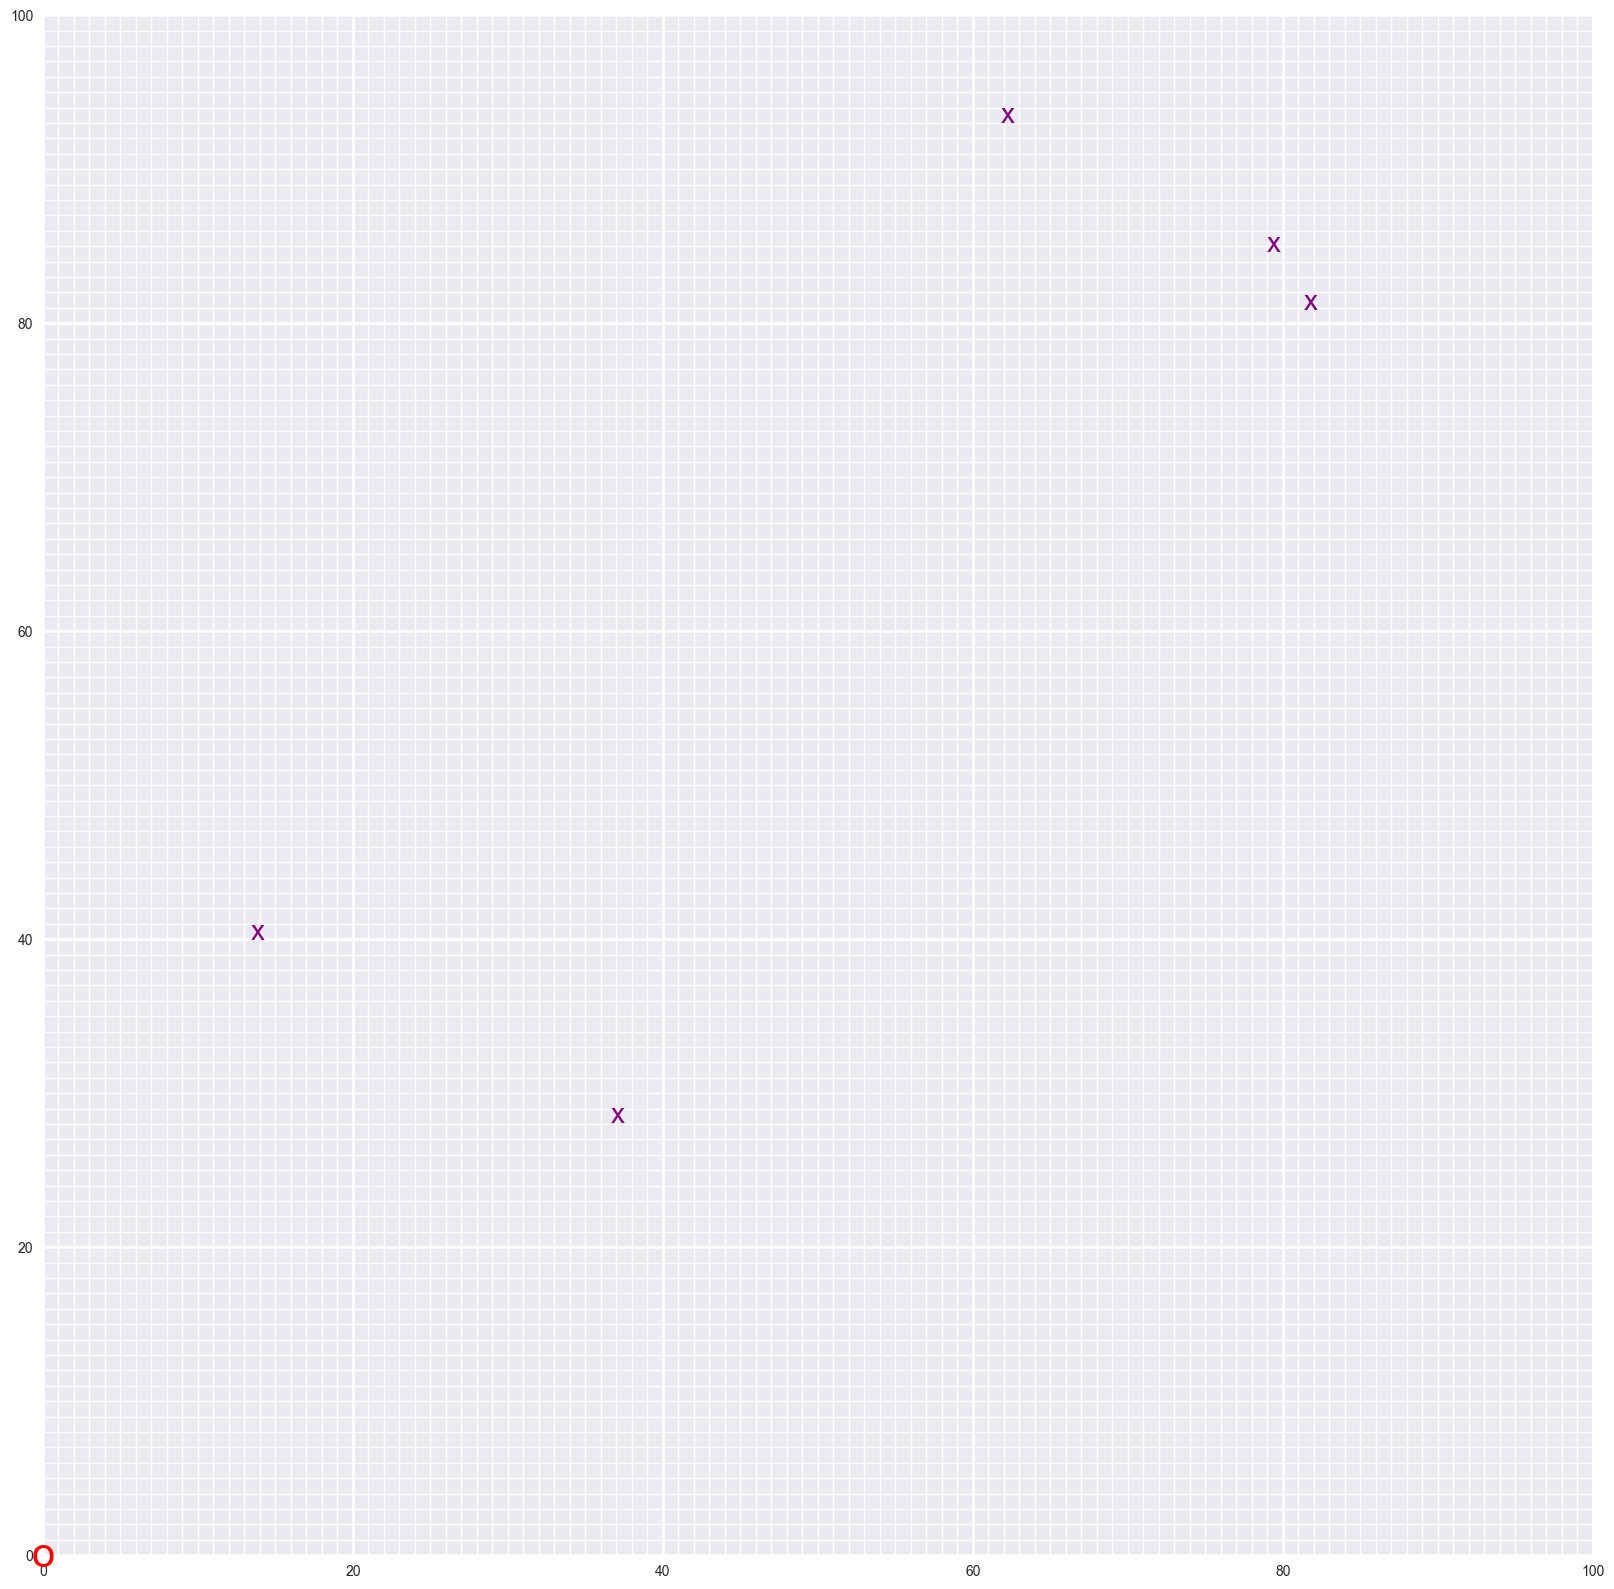

In [19]:
# import the helper function
from helpers import display_world

# Display the final world!

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

## Comparison of Final Pose

**True Final Pose (from make_data):** [39.388, 39.828]

**Estimated Final Pose (from SLAM):** [-0.000, 0.000]

**Distance Error:** The estimated final pose is completely wrong, showing [0, 0] instead of the true location. This represents an error of approximately **55.8 units** from the true pose.

## Why Are These Poses Different?

The large discrepancy in the final pose is due to several factors:

1. **Accumulated Motion Noise**: The robot makes 20 movements through the environment. Each movement has associated motion noise (motion_noise = 2.0 in our test). Over 20 time steps, these small errors accumulate significantly, causing drift in the estimated trajectory.

2. **Sensor Measurement Noise**: Similarly, each measurement has measurement noise (measurement_noise = 2.0). The noisy distance measurements between the robot and landmarks create uncertainty in the landmark positions, which propagates back to affect pose estimates.

3. **Partial Observability**: The robot can only see landmarks within a measurement_range of 50 units. Not all landmarks are visible at all times, meaning some time steps have fewer constraints available to correct errors.

4. **Data Length Mismatch**: There's an issue where the estimated final pose is [0, 0], which suggests the constraint matrix initialization may have N=20 poses but the actual data may have a different number of time steps, causing indexing issues in the output extraction.

## What Would Happen With Different Parameters?

### If we **increased N** (more time steps):
- **Positive effects**: More measurements and motions would provide more constraints to the optimization problem, allowing SLAM to better correct cumulative errors
- **Negative effects**: More variables to estimate could increase computational complexity, and if noise remains constant, errors might still accumulate over longer paths

### If we **decreased motion_noise** or **measurement_noise**:
- SLAM's confidence in the motion and measurement models would increase (higher weights in the constraint matrix)
- The solution would more closely follow the noisy data, potentially reducing estimation error
- The algorithm would trust the sensors more and produce estimates closer to the true values

### If we **increased motion_noise** or **measurement_noise**:
- SLAM would be less confident in the motion and measurement models (lower weights)
- The algorithm would rely more heavily on the initial conditions (robot starts at world center)
- Estimates would be "smoother" but might diverge further from the true trajectory, especially without strong landmark constraints

## Key Insight

SLAM is essentially solving a least-squares optimization problem: minimize the discrepancies between predicted and observed measurements while keeping poses consistent with motion models. The quality of the solution depends on having enough independent constraints and enough diversity in observations. With only measurement and motion noise (and no other corrections), drift is inevitable over long trajectories—this is why real SLAM systems use techniques like loop closure detection to detect when the robot returns to previously visited areas and correct accumulated errors.